# Produce multiband GeoTIFFs for each Landsat observation, given a shapefile

| Authors:  | Bex Dunn|
|----------|----------------|
| Created: | Feb 20, 2019 |
| Last edited: | Feb 20, 2019 |

**Requirements:**

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`

This notebook assumes you have cloned the dea-notebooks repository by following the instructions on [DEA notebooks using command line git](https://github.com/GeoscienceAustralia/dea-notebooks#dea-notebooks-using-command-line-git) or [DEA notebooks using Github](https://github.com/GeoscienceAustralia/dea-notebooks#dea-notebooks-using-github). If you didn't, you will need to download any scripts that fail in the first cell into your relative directory so that the notebook will have access to those scripts. `"../"` means the directory above the directory you are working in, and `"./"` means the current directory. 

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).



__Background:__ Data from the [Landsat](https://landsat.usgs.gov/about-landsat) 5,7 and 8 satellite missions are accessible through [Digital Earth Australia](http://www.ga.gov.au/about/projects/geographic/digital-earth-australia) (DEA). 

The *Tasseled Cap Index (TCI)* is a method of reducing 6 bands of satellite data (BLUE, GREEN, RED, NIR, SWIR1, SWIR2) to 3 bands (Brightness, Greenness, Wetness) using a Principal Components Analysis and Procrustes' Rotation [(Roberts et al 2018)](##References). This notebook uses the published coefficients of [Crist 1985](##References) as applied to Digital Earth Australia's Landsat satellite data.This notebook produces the wetness index.

__What does this notebook do?:__ This notebook takes a supplied shapefile of a polygon and queries the datacube Landsat surface reflectance data. It calculates tasselled cap wetness. The results and input surface reflectance are output as geotiffs for each individual scene.

### import modules and scripts

In [1]:
import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import rasterio.mask
import rasterio.features
from shapely import geometry
import sys
import xarray as xr

#import matplotlib.dates as mdates
#import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from datacube.storage import masking
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser, write_geotiff

sys.path.append('../10_Scripts')
import DEADataHandling, DEAPlotting, TasseledCapTools

dc = datacube.Datacube(app='landsat')

%load_ext autoreload

%autoreload 2

### Set up polygon

In [2]:
#change the path here if you want a different polygon
poly_path = '/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_shapefiles/reeves_lake_for_demo.shp'

In [3]:
#open the polygon
with fiona.open(poly_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

<Figure size 432x288 with 0 Axes>

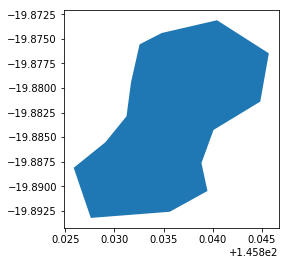

In [4]:
#plot polygon to check it looks ok
plt.clf()
shape_plot = gpd.read_file(poly_path)
shape_plot.plot()
plt.show()

### set up DEA query

In [5]:
query = {'geopolygon': geom,
         'time': ('2016-05-01', '2016-05-30')
         }

## Set up datasets

### set cloudmasking threshold and load landsat nbart data

In [6]:
#load landsat nbart data with standard set cloudmasking threshold of 0%. Check function definition for load_clearlandsat.
ls578_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart')

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 1 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


### mask the data with our original polygon to remove extra data 

In [7]:
data = ls578_ds
mask = rasterio.features.geometry_mask([geom.to_crs(data.geobox.crs)for geoms in [geom]],
                                           out_shape=data.geobox.shape,
                                           transform=data.geobox.affine,
                                           all_touched=False,
                                           invert=False)

In [8]:
#for some reason xarray is not playing nicely with our old masking function
mask_xr = xr.DataArray(mask, dims = ('y','x'))
ls578_ds = data.where(mask_xr==False)

### Plot our data as a false color image 

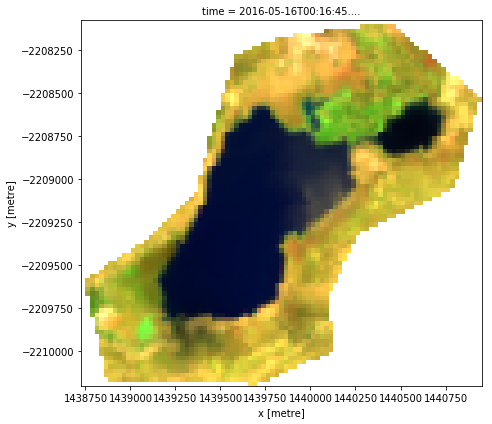

In [9]:
DEAPlotting.rgb(ls578_ds, bands=['swir1', 'nir', 'green'], col='time',col_wrap=4)

## Write geotiffs for each time we have imagery

### set up paths to write out outputs to

In [10]:
#get polygon name from the polygon path
polyname = poly_path.split('/')[-1].split('.')[0]

### change the path below to a path where you'd like things saved!

In [11]:
savefilepath = '/g/data/r78/rjd547/tmp/'+polyname
print(f'your GeoTIFFs will write to {savefilepath}')

your GeoTIFFs will write to /g/data/r78/rjd547/tmp/reeves_lake_for_demo


### write GeoTIFFs for each timestep

In [12]:
#set dataset equal to landsat dataset
ds = ls578_ds
#write a geotiff to file for each timestep
if len(ds.time)==1:
    print('one timestep')
    for timestep in range(len(ds.time)):
        timestep_date =np.datetime_as_string(ds.time.isel(time=timestep))[0:10]
        #drop the time dimension for only one timestep
        #write the dataset without the data percentage to file
        try:
            ds1 = ds.squeeze()
            #ds1 = ds1.drop('data_perc')
            write_geotiff(savefilepath+'_LS_'+timestep_date+'.tif', ds1)
            #complain if the file already exists but don't fail    
            print('wrote to GeoTIFF' )
        except RuntimeError as err:
            print("RuntimeError: {0}".format(err))

elif len(ds.time)>1:
    print('multiple timesteps') 
    #remove data percentage as it breaks the geotiff writer
    #ds = ds.drop('data_perc')
    for timestep in range(len(ds.time)):
        timestep_date =np.datetime_as_string(ds.time.isel(time=timestep))[0:10]
        try:
            write_geotiff(savefilepath+'_LS_'+timestep_date+'.tif', ds.isel(time =timestep))
            #complain if the file already exists but don't fail    
            print('wrote to GeoTIFF' )
        except RuntimeError as err:
            print("RuntimeError: {0}".format(err))

one timestep
wrote to GeoTIFF
